In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

SRC = Path("__file__").resolve().parents[0]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import src.config as cfg

In [5]:
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"loading final dataset from: {final_data_path}")
df = pd.read_parquet(final_data_path)

loading final dataset from: C:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet


In [6]:
# Drop rows with missing targets and ensure chronological order
targets = ["NO2", "PM2.5"]
df_clean = df.dropna(subset=targets).copy()
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean = df_clean.sort_values(['SiteID', 'date'])  # sort before lag features
print(f"Data prepared for modeling. Shape: {df_clean.shape}")

Data prepared for modeling. Shape: (901136, 47)


In [7]:
# create lagged features before any splits to prevent leakage
for target in targets:
    # Create lag features
    for lag in [1, 3, 6, 24]:
        df_clean[f'{target}_lag_{lag}hr'] = df_clean.groupby('SiteID')[target].shift(lag)
    
    # Create rolling features
    df_clean[f'{target}_roll_3hr'] = (
        df_clean
        .groupby('SiteID')[target]
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )

In [9]:
split_date = '2024-01-01'
train_mask = df_clean['date'] < split_date
test_mask = df_clean['date'] >= split_date

# Define base features
features = [col for col in df_clean.columns if col not in targets + ['date', 'SiteID']]
X = df_clean[features]
y = df_clean[targets]

# Split using masks
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")

Training data shape: (857420, 53)
Testing data shape:  (43716, 53)


C:\Users\clown\AppData\Local\Temp\ipykernel_10924\1845160212.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='mako', legend=False)


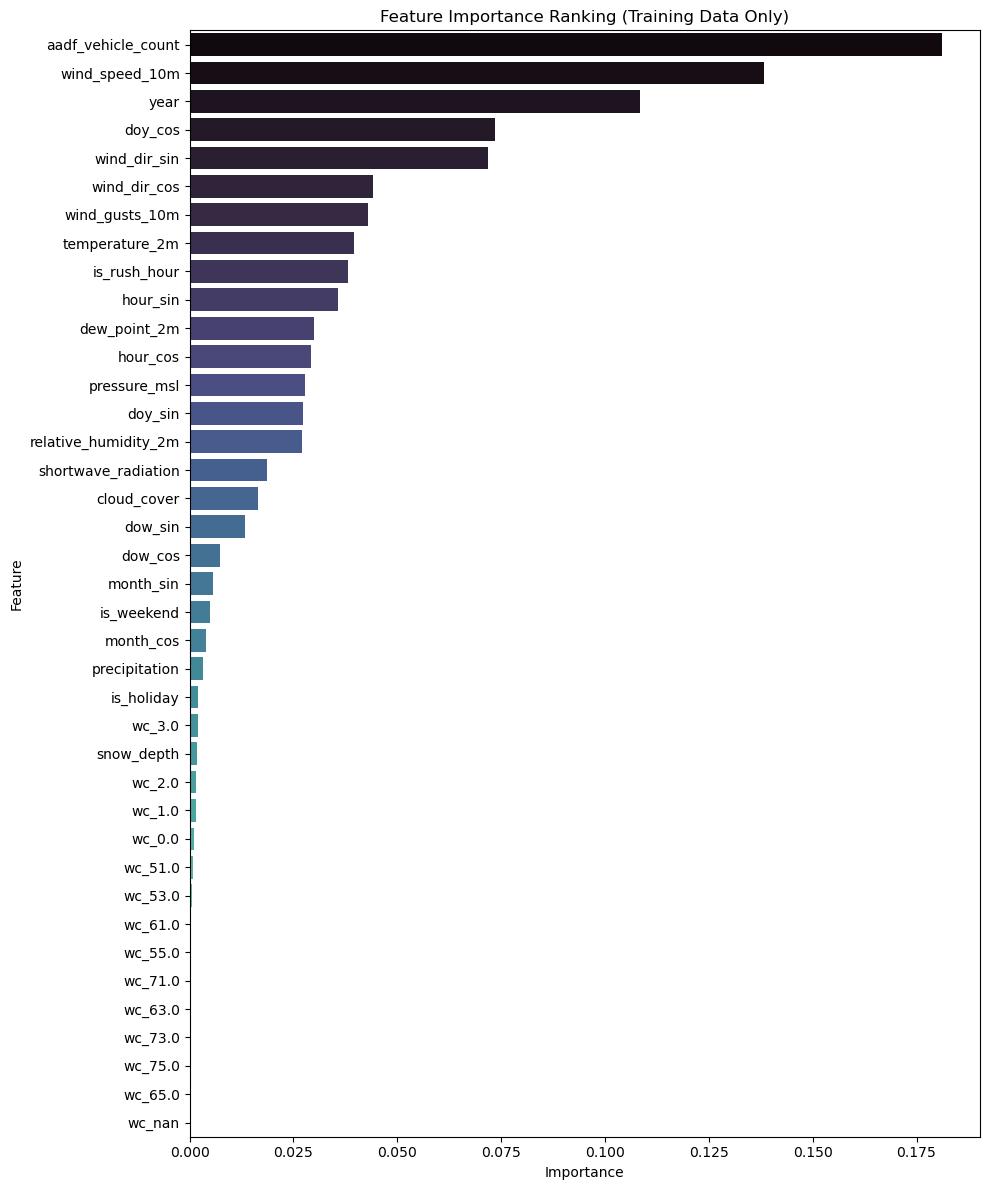

Selected 25 final features for modeling.


In [10]:
# Remove original time features to focus on cyclical encodings
original_time_cols = ['month', 'day_of_week', 'day_of_year', 'hour']
initial_features = [
    col for col in features 
    if col not in original_time_cols and 
       not col.startswith(tuple(targets))  # Exclude target-derived features
]

# Sample from training data only
X_initial_train = X_train[initial_features]
y_initial_train = y_train
X_sample = X_initial_train.sample(frac=0.25, random_state=42)
y_sample = y_initial_train.loc[X_sample.index]

# Train feature selector
rf_selector = RandomForestRegressor(n_estimators=60, random_state=42, n_jobs=-1)
rf_selector.fit(X_sample, y_sample)

# Get feature importances
importances = pd.Series(
    rf_selector.feature_importances_, 
    index=X_initial_train.columns
).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 12))
sns.barplot(x=importances.values, y=importances.index, palette='mako', legend=False)
plt.title('Feature Importance Ranking (Training Data Only)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Select top features
FINAL_FEATURES = importances.head(25).index.tolist()

for feat in ['aadf_vehicle_count', 'is_rush_hour', 'is_weekend']:
    if feat not in FINAL_FEATURES:
        FINAL_FEATURES.append(feat)
print(f"Selected {len(FINAL_FEATURES)} final features for modeling.")

In [11]:
# Identify lag/roll columns
lag_roll_cols = [col for col in X_train.columns if '_lag_' in col or '_roll_' in col]

# Calculate medians from TRAINING data only
medians = X_train[lag_roll_cols].median()

# Apply to both sets
X_train.fillna(medians, inplace=True)
X_test.fillna(medians, inplace=True)

# Subset final features
X_train = X_train[FINAL_FEATURES]
X_test = X_test[FINAL_FEATURES]

C:\Users\clown\AppData\Local\Temp\ipykernel_10924\2493579286.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(medians, inplace=True)
C:\Users\clown\AppData\Local\Temp\ipykernel_10924\2493579286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(medians, inplace=True)


In [12]:
print("\nTraining final model...")
final_rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=10
)
final_rf_model.fit(X_train, y_train)
print("Training complete.")


Training final model...
Training complete.


In [14]:
print("\nEvaluating final model performance on test set...")
y_pred = final_rf_model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=targets, index=y_test.index)

# Evaluate NO2
mae_no2 = mean_absolute_error(y_test['NO2'], y_pred_df['NO2'])
r2_no2 = r2_score(y_test['NO2'], y_pred_df['NO2'])
print(f"\n--- NO2 Performance ---")
print(f"Mean Absolute Error (MAE): {mae_no2:.2f}")
print(f"R-squared (R²):            {r2_no2:.2f}")

# Evaluate PM2.5
mae_pm25 = mean_absolute_error(y_test['PM2.5'], y_pred_df['PM2.5'])
r2_pm25 = r2_score(y_test['PM2.5'], y_pred_df['PM2.5'])
print(f"\n--- PM2.5 Performance ---")
print(f"Mean Absolute Error (MAE): {mae_pm25:.2f}")
print(f"R-squared (R²):            {r2_pm25:.2f}")


Evaluating final model performance on test set...

--- NO2 Performance ---
Mean Absolute Error (MAE): 8.66
R-squared (R²):            0.51

--- PM2.5 Performance ---
Mean Absolute Error (MAE): 4.53
R-squared (R²):            0.27
